In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime
from pylab import rcParams
import matplotlib.pyplot as plt
import warnings
import itertools
import statsmodels.api as sm
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.metrics import mean_squared_error
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import math
from sklearn.preprocessing import MinMaxScaler
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
dateparse1 = lambda x1: pd.datetime.strptime(x1,"%m/%d/%Y")
data = pd.read_csv('test 1- crude oil/dataset/Europe_Brent_Spot_Price_FOB (2).csv',parse_dates=['Date'], date_parser=dateparse1)
data = data.reindex(index=data.index[::-1])
df = data
data.head()
df = df.sort_values('Date')
df = df.groupby('Date')['Price'].sum().reset_index()
df.set_index('Date', inplace=True)
df=df.loc[datetime.date(year=1988,month=1,day=1):]

In [3]:
#dateparse = lambda x: pd.datetime.strptime(x, '%b %d, %Y')
#Read csv file
#df = pd.read_csv('test 1- crude oil/dataset/BrentOilPrices.csv',parse_dates=['Date'], date_parser=dateparse)
#Sort dataset by column Date
#df = df.sort_values('Date')
#df = df.groupby('Date')['Price'].sum().reset_index()
#df.set_index('Date', inplace=True)
#df=df.loc[datetime.date(year=2000,month=1,day=1):]

In [4]:
def DfInfo(df_initial):
    # gives some infos on columns types and numer of null values
    tab_info = pd.DataFrame(df_initial.dtypes).T.rename(index={0: 'column type'})
    tab_info = tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0: 'null values (nb)'}))
    tab_info = tab_info.append(pd.DataFrame(df_initial.isnull().sum() / df_initial.shape[0] * 100).T.
                               rename(index={0: 'null values (%)'}))
    return tab_info

In [5]:
df.head()

,Price
Date,
1988-01-04,17.95
1988-01-05,17.08
1988-01-06,17.90
1988-01-08,16.88
1988-01-11,16.65


In [6]:
DfInfo(df)

,Price
column type,float64
null values (nb),0
null values (%),0.0


In [7]:
df.index

DatetimeIndex(['1988-01-04', '1988-01-05', '1988-01-06', '1988-01-08',
               '1988-01-11', '1988-01-12', '1988-01-13', '1988-01-14',
               '1988-01-15', '1988-01-18',
               ...
               '2022-07-19', '2022-07-20', '2022-07-21', '2022-07-22',
               '2022-07-25', '2022-07-26', '2022-07-27', '2022-07-28',
               '2022-07-29', '2022-08-01'],
              dtype='datetime64[ns]', name='Date', length=8776, freq=None)

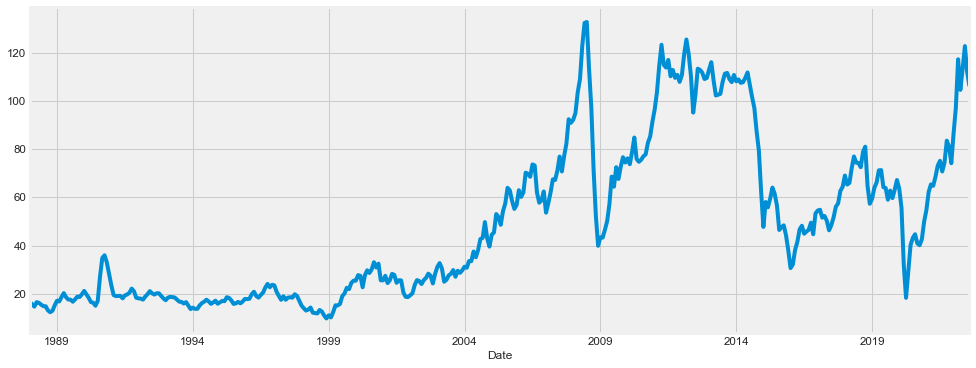

In [8]:
y = df['Price'].resample('MS').mean()
y.plot(figsize=(15, 6))
plt.show()

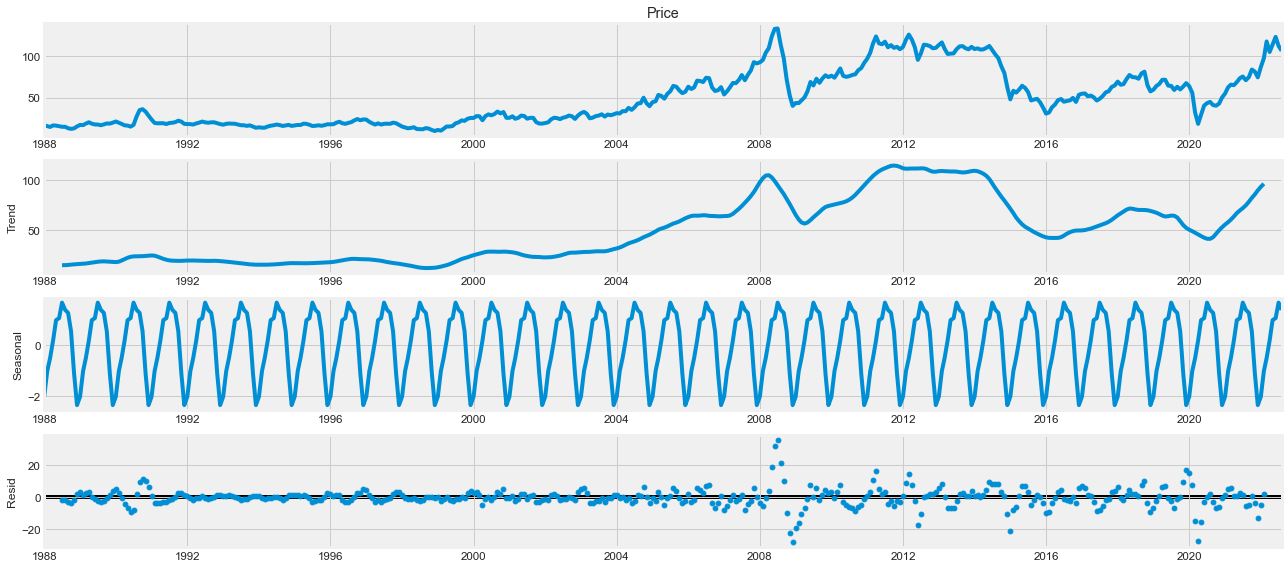

In [9]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()


In [10]:
sc = MinMaxScaler(feature_range = (0, 1))
df = sc.fit_transform(df)

In [11]:
# split into train and test sets
train_size = int(len(df) * 0.70)
test_size = len(df) - train_size
train, test = df[0:train_size, :], df[train_size:len(df), :]
print(train,"\n****************************\n")
print(test,"\n****************************\n")

[[0.06562848]
 [0.05917686]
 [0.06525769]
 ...
 [0.87415647]
 [0.84931405]
 [0.8601409 ]] 
****************************

[[0.86510938]
 [0.85487579]
 [0.85124212]
 ...
 [0.74586578]
 [0.75943641]
 [0.7192436 ]] 
****************************



In [12]:
# convert an array of values into a data_set matrix def
def create_data_set(_data_set, _look_back=1):
    data_x, data_y = [], []
    for i in range(len(_data_set) - _look_back - 1):
        a = _data_set[i:(i + _look_back), 0]
        data_x.append(a)
        data_y.append(_data_set[i + _look_back, 0])
    return np.array(data_x), np.array(data_y)


In [13]:
# reshape into X=t and Y=t+1
look_back =90
X_train,Y_train,X_test,Ytest = [],[],[],[]
X_train,Y_train=create_data_set(train,look_back)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test,Y_test=create_data_set(test,look_back)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_train, "\n---------------------\n")
print(Y_train, "\n---------------------\n")
print(X_test, "\n---------------------\n")
print(Y_test)

[[[0.06562848]
  [0.05917686]
  [0.06525769]
  ...
  [0.05398591]
  [0.05472747]
  [0.05413422]]

 [[0.05917686]
  [0.06525769]
  [0.05769373]
  ...
  [0.05472747]
  [0.05413422]
  [0.05487579]]

 [[0.06525769]
  [0.05769373]
  [0.05598813]
  ...
  [0.05413422]
  [0.05487579]
  [0.05561735]]

 ...

 [[0.73659622]
  [0.72576937]
  [0.75431961]
  ...
  [0.8814238 ]
  [0.88231368]
  [0.87630701]]

 [[0.72576937]
  [0.75431961]
  [0.75387468]
  ...
  [0.88231368]
  [0.87630701]
  [0.88275862]]

 [[0.75431961]
  [0.75387468]
  [0.76470152]
  ...
  [0.87630701]
  [0.88275862]
  [0.87415647]]] 
---------------------

[0.05487579 0.05561735 0.05561735 ... 0.88275862 0.87415647 0.84931405] 
---------------------

[[[0.86510938]
  [0.85487579]
  [0.85124212]
  ...
  [0.70945495]
  [0.72080089]
  [0.72258065]]

 [[0.85487579]
  [0.85124212]
  [0.84086022]
  ...
  [0.72080089]
  [0.72258065]
  [0.7180571 ]]

 [[0.85124212]
  [0.84086022]
  [0.86103077]
  ...
  [0.72258065]
  [0.7180571 ]
  [0.7243

In [14]:
# create and fit the LSTM network regressor = Sequential() 
regressor = Sequential()

regressor.add(LSTM(units = 60, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.1))

regressor.add(LSTM(units = 60, return_sequences = True))
regressor.add(Dropout(0.1))

regressor.add(LSTM(units = 60))
regressor.add(Dropout(0.1))

regressor.add(Dense(units = 1))


regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
reduce_lr = ReduceLROnPlateau(monitor='val_loss',patience=5)
history =regressor.fit(X_train, Y_train, epochs = 20, batch_size = 15,validation_data=(X_test, Y_test), callbacks=[reduce_lr],shuffle=False)

Epoch 1/20
404/404 [==============================] - 31s 64ms/step - loss: 0.0032 - val_loss: 0.1507 - lr: 0.0010
Epoch 2/20
404/404 [==============================] - 27s 68ms/step - loss: 0.0119 - val_loss: 0.0813 - lr: 0.0010
Epoch 3/20
404/404 [==============================] - 29s 73ms/step - loss: 0.0099 - val_loss: 0.0507 - lr: 0.0010
Epoch 4/20
404/404 [==============================] - 28s 70ms/step - loss: 0.0047 - val_loss: 0.0276 - lr: 0.0010
Epoch 5/20
404/404 [==============================] - 28s 68ms/step - loss: 0.0017 - val_loss: 0.0062 - lr: 0.0010
Epoch 6/20
404/404 [==============================] - 28s 69ms/step - loss: 0.0012 - val_loss: 0.0066 - lr: 0.0010
Epoch 7/20
404/404 [==============================] - 28s 70ms/step - loss: 0.0012 - val_loss: 0.0096 - lr: 0.0010
Epoch 8/20
404/404 [==============================] - 28s 70ms/step - loss: 0.0014 - val_loss: 0.0116 - lr: 0.0010
Epoch 9/20
404/404 [==============================] - 29s 71ms/step - loss: 0.00

In [15]:
train_predict = regressor.predict(X_train)
test_predict = regressor.predict(X_test)

In [16]:
# invert predictions
train_predict = sc.inverse_transform(train_predict)
Y_train = sc.inverse_transform([Y_train])
test_predict = sc.inverse_transform(test_predict)
Y_test = sc.inverse_transform([Y_test])

Train Mean Absolute Error: 3.2108235252604764
Train Root Mean Squared Error: 3.58218821353547
Test Mean Absolute Error: 1.8693208576205391
Test Root Mean Squared Error: 2.546933455643361


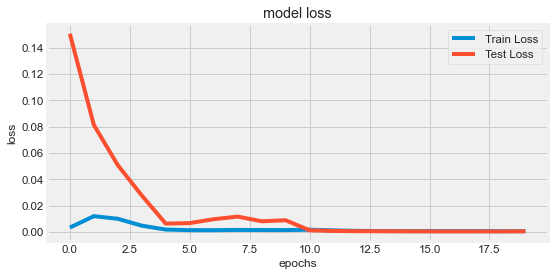

In [17]:
print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

(2542, 1)


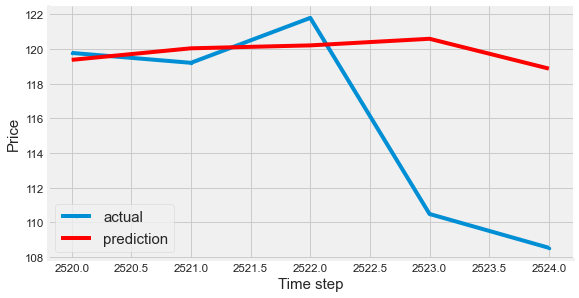

In [20]:
#Compare Actual vs. Prediction

print(test_predict.shape)

aa=[x for x in range(2520,2525)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][2520:2525], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][2520:2525], 'r', label="prediction")
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Price', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();